In [1]:
%matplotlib inline

In [2]:
import MDAnalysis as mda
import ARPDF, utils
import importlib
import matplotlib.pyplot as plt

importlib.reload(ARPDF)
importlib.reload(utils)
from ARPDF import *


In [3]:
# u1 = mda.Universe('data/CCl4/CCl4.gro')
# u2 = mda.Universe('data/CCl4/CCl4_modified.gro')
# modified_atoms = [515, 516, 517, 518, 519, 645]
# polar_axis = [0.85692924,0.47545751,0.19902873]
# ori_range = 9.924650203173275
# X, Y, ARPDF_exp = utils.preprocess_ARPDF(np.load("data/CCl4/ARPDF_exp.npy"), ori_range, rmax=9.0)
X, Y, ARPDF_exp = utils.load_exp_data('data/CCl4', rmax=9.0)
u1, u2, modified_atoms, polar_axis = utils.load_structure_data('data/CCl4')
filter_fourier = lambda kX, kY, xp: (1 - xp.exp(-(kX**2 / 0.3 + kY**2 / 0.1)))**3 * xp.exp(-0.08 * (kX**2 + kY**2))

Using cupy to compute ARPDF...
Selected 461 atoms for universe 1, 477 atoms for universe 2.
Computing fields of universe 1...
Computed field for C-C: 118 atom pairs.
Computed field for C-CL: 679 atom pairs.
Computed field for CL-CL: 907 atom pairs.
Computing fields of universe 2...
Computed field for C-C: 118 atom pairs.
Computed field for C-CL: 674 atom pairs.
Computed field for CL-CL: 906 atom pairs.
Computing ARPDF...


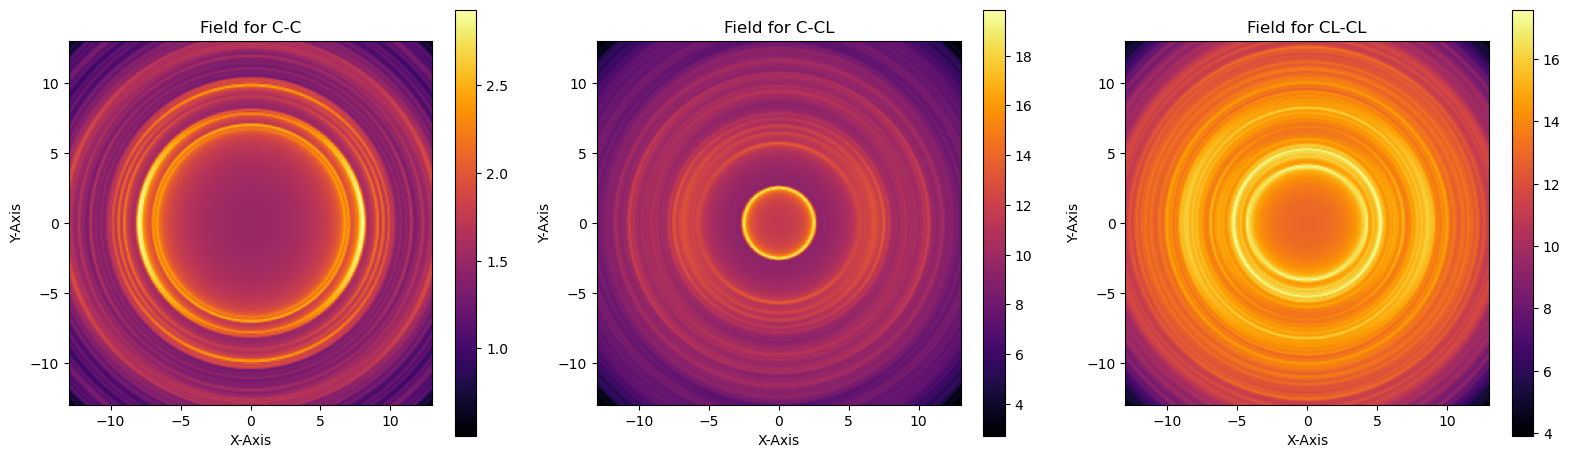

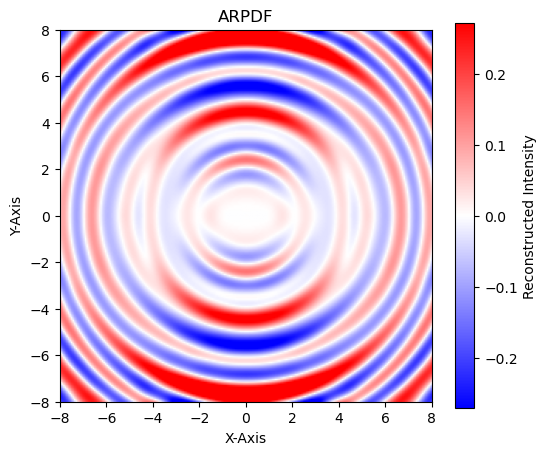

In [5]:
ARPDF = compute_ARPDF(u1, u2, cutoff=13.0, N=512, grids_XY=(X, Y), modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, filter_fourier=filter_fourier, verbose=True)

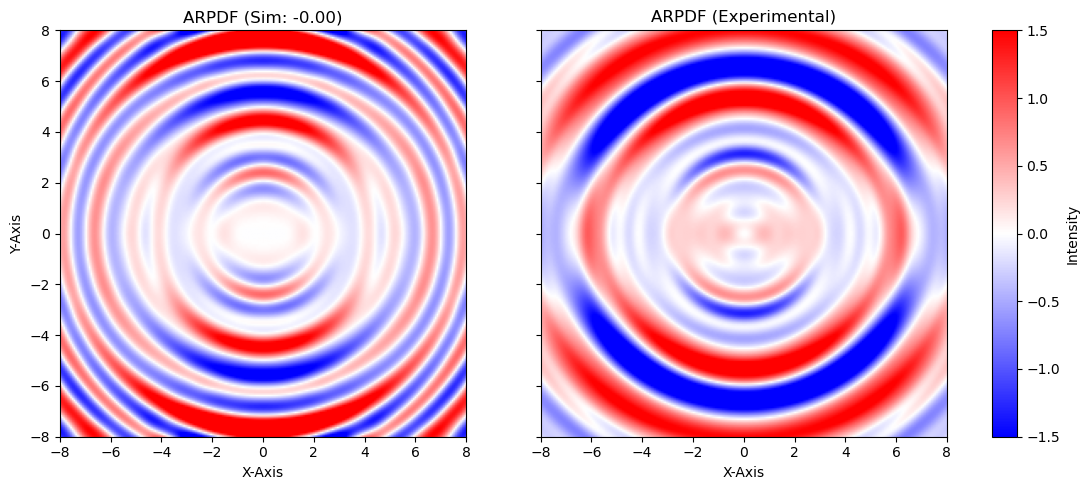

In [6]:
fig = compare_ARPDF(ARPDF, ARPDF_exp, (X, Y), show_range=8.0)
fig.savefig("tmp/ARPDF_example.png")

In [7]:
pos1 = u1.atoms[modified_atoms].positions
pos2 = u2.atoms[modified_atoms].positions
_u2 = u2.copy()
ARPDFs = []
for i, t in enumerate(np.linspace(0, 1, 20)):
    _u2.atoms[modified_atoms].positions = pos1 * (1 - t) + pos2 * t
    ARPDFs.append(compute_ARPDF(u1, _u2, cutoff=10.0, N=512, modified_atoms=modified_atoms, polar_axis=polar_axis, periodic=True, 
                                filter_fourier=filter_fourier, verbose=False))


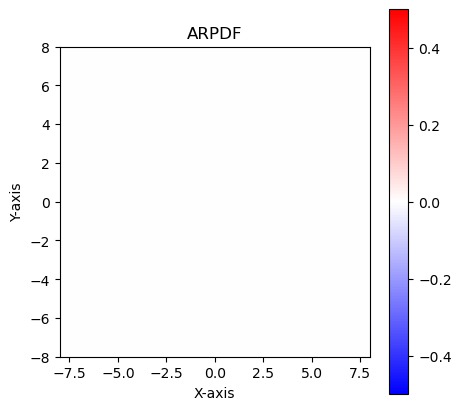

In [8]:
from matplotlib import pyplot as plt, animation
# 创建画布和初始图像
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(ARPDFs[0], origin="lower", cmap="bwr", extent=[-10, 10, -10, 10])
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title("ARPDF")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
im.set_clim(-0.5, 0.5)
fig.colorbar(im, ax=ax)

In [9]:

# 更新函数：用于更新每一帧的图像
def update(frame):
    im.set_array(ARPDFs[frame])
    return [im]

# 创建动画 (frames 指定帧数, interval 控制帧间隔时间)
ani = animation.FuncAnimation(fig, update, frames=len(ARPDFs), interval=100, blit=True)

# 显示动画 (仅在 Jupyter Notebook 中运行)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [10]:
ani.save("tmp/ARPDF.gif", writer="pillow", fps=10)